In [ ]:
# Setup NASLib
%cd /content
!git clone -b zerocost https://github.com/automl/NASLib/
!pip install gdown

/content
Cloning into 'NASLib'...
remote: Enumerating objects: 48614, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 48614 (delta 224), reused 364 (delta 203), pack-reused 48214
Receiving objects: 100% (48614/48614), 530.29 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (39026/39026), done.
Checking out files: 100% (277/277), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download zc score files
%cd NASLib
!source scripts/bash_scripts/download_nbs_zero.sh all
%cd ..

/content/NASLib
search_space = all
tnb101 files no exist
Downloading...
From: https://drive.google.com/uc?id=1teH8JcQsamZngUD_DMQyNkCoUYYSTM0M
To: /content/NASLib/naslib/data/zc_transbench101_macro.json
100% 20.7M/20.7M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SBOVAyhLCBTAJiU_fo7hLRknNrGNqFk7
To: /content/NASLib/naslib/data/zc_transbench101_micro.json
100% 26.5M/26.5M [00:00<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RddgmwqjWJ1czGT8gEPB8qqhUHazp92G
To: /content/NASLib/naslib/data/zc_nasbench301.json
100% 12.4M/12.4M [00:00<00:00, 95.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R7n7GpFHAjUZpPISzbhxH0QjubnvZM5H
To: /content/NASLib/naslib/data/zc_nasbench201.json
100% 44.3M/44.3M [00:00<00:00, 92.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rkse44EWgYdBS34iyhjSs9Y2l0fxPCpU
To: /content/NASLib/naslib/data/zc_nasbench101.json
100% 10.6M/10.6M [00:00<00:00, 69.6MB/s]
/content


## Functions

In [ ]:
import pandas as pd


def parse_scores(searchspace):
    searchspace_keys = [k for k in searchspace.keys()]
    
    arch_data = searchspace[searchspace_keys[0]]['(2, 3, 2, 3, 2, 3)']
    score_keys = [k for k in arch_data.keys() if k != 'id' and k != 'val_accuracy']
    
    # convert to DataFrame
    nets = {k: [] for k in searchspace_keys}
    val_accs = {k: [] for k in searchspace_keys}
    scores = {k: {s: [] for s in score_keys} for k in searchspace_keys}

    # get only scores without running time
    for task in searchspace.keys():
        for net, arch_scores in searchspace[task].items():
            for s in score_keys:
                scores[task][s].append(arch_scores[s]['score'])

            val_accs[task].append(arch_scores['val_accuracy'])
            nets[task].append(net)
            
    dfs = {}
    for k in val_accs.keys():
        dfs[k] = pd.DataFrame({'net': nets[k], 'val_accs': val_accs[k], **scores[k]})
        
    return dfs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

    
def common_n_largest(dfs, n_largest=50, plot=True):
    """Return common top performing networks of dataset pairs."""
    largest_dfs = {k: df.nlargest(n_largest, 'val_accs') for k, df in dfs.items()}
    
    common_nets = np.zeros((len(largest_dfs), len(largest_dfs)))
    indices = {k: i for i, k in enumerate(largest_dfs.keys())}

    # get common architectures
    for k1, ldf_1 in largest_dfs.items():
        for k2, ldf_2 in largest_dfs.items():
            i, j = indices[k1], indices[k2]
            if i > j:
                common_nets[i, j] = common_nets[j, i]
                continue

            common_nets[i, j] = len(ldf_1) if k1 == k2 else len(set(ldf_1['net']).intersection(set(ldf_2['net'])))
            
    if plot:
        plt.title(f"Common nets between top {n_largest} nets of searchspaces")
        sns.heatmap(common_nets, annot=True, xticklabels=list(indices.keys()), yticklabels=list(indices.keys()))
        plt.show()
        
    return common_nets

In [ ]:
def do_subplots(n_total, columns=3, **kwargs):
    fig, axs = plt.subplots(int(np.ceil(n_total / columns)), columns, **kwargs)
    axs = axs.flatten()
    
    for i in range(n_total, len(axs)):
        fig.delaxes(axs[i])
    
    return fig, axs.flatten()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


def plot_acc_hist(dfs, figsize=(12, 9)):
    fig, axs = do_subplots(len(dfs), figsize=figsize)
    plt.suptitle("Histogram of validation accuracies per task.")

    for (task, df), ax in zip(dfs.items(), axs):
        ax.set_title(task)
        sns.histplot(df['val_accs'], ax=ax, bins=50)

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
def get_tau_str(accs, scores, task):
    tau = scipy.stats.kendalltau(accs, scores)
    return f"{task}, Kendall $\\tau =$ {np.round(tau.correlation, 2)}"

In [ ]:
from scipy import stats

def plot_proxies(dfs, zc, figsize=(12, 9), top_k=3):
    fig, axs = do_subplots(len(dfs), figsize=figsize)

    for (task, df), ax in zip(dfs.items(), axs):
        tau_str = get_tau_str(df['val_accs'], df[zc], task)
        ax.set_title(tau_str)

        df = df[(np.abs(stats.zscore(df['val_accs'])) < 3)]

        quantile = df['val_accs'].quantile(0.9)
        top_nets = df[df['val_accs'] > quantile]

        top_zc = top_nets[zc].quantile(0.9)

        ax.hlines(top_zc, df['val_accs'].min(), df['val_accs'].max(), color='r')

        sns.scatterplot(data=df, x='val_accs', y=zc, ax=ax)
        sns.scatterplot(data=top_nets, x='val_accs', y=zc, ax=ax)

        best_nets = top_nets.nlargest(top_k, 'val_accs')
        sns.scatterplot(data=best_nets, x='val_accs', y=zc, ax=ax)

    fig.suptitle(f"Zero cost proxy score ({zc}) and val accs.")
    fig.legend(loc='upper left', labels=['top 10% zc scores', 'low acc nets', 'best 10% nets', f'best {top_k} nets'])
    fig.tight_layout()
    plt.subplots_adjust(top=0.87)
    plt.show()

In [ ]:
import scipy.stats

def plot_top_proxies(dfs, zc, figsize=(12, 9)):
    fig, axs = do_subplots(len(dfs), figsize=figsize)

    for (task, df), ax in zip(dfs.items(), axs):
        quantile = df['val_accs'].quantile(0.9)
        top_nets = df[df['val_accs'] > quantile]

        tau_str = get_tau_str(top_nets['val_accs'], top_nets[zc], task)
        ax.set_title(tau_str)

        sns.scatterplot(data=top_nets, x='val_accs', y=zc, ax=ax)

    plt.suptitle(f"Top 10% networks (by accuracy) - zero cost proxy score ({zc}) and val accs.")
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
from functools import reduce

def get_top_nets(df, filter_zc, quantile):
  q = df[filter_zc].quantile(quantile)
  top_nets = df[df[filter_zc] > q]
  return top_nets

def filter_by_zc(dfs, filter_zc, quantile=0.9, mode='u'):
  for (task, df) in dfs.items():
    if isinstance(filter_zc, str) or len(filter_zc) == 1:
      filter_zc = filter_zc if isinstance(filter_zc, str) else filter_zc[0]
      yield task, get_top_nets(df, filter_zc, quantile)
      continue

    top_nets = [get_top_nets(df, zc, quantile).index for zc in filter_zc]
    if mode == 'u' or mode == 'union':
      index = reduce(lambda ix1, ix2: ix1.union(ix2), top_nets)
    elif mode == 'i' or mode == 'intersection':
      index = reduce(lambda ix1, ix2: ix1.intersection(ix2), top_nets)
    elif mode == 's' or mode == 'stack':
      top_df = reduce(lambda df2, zc: get_top_nets(df2, zc, quantile), filter_zc, df)
      yield task, top_df
      continue
    else:
      raise ValueError(f"Invalid mode: {mode}, possible u (union), i (intersection), s (stack).")
    
    yield task, df.loc[index]

In [ ]:
def plot_top_proxies_filtered(dfs, zc, filter_zc, quantile=0.9, top_k=3, figsize=(12, 9), mode='u'):
    fig, axs = do_subplots(len(dfs), figsize=figsize)

    for (task, top_nets), ax in zip(filter_by_zc(dfs, filter_zc, quantile=quantile, mode=mode), axs):
      df = dfs[task]
      print(len(top_nets))

      tau_str = get_tau_str(top_nets['val_accs'], top_nets[zc], task)
      ax.set_title(tau_str)

      sns.scatterplot(data=top_nets, x='val_accs', y=zc, ax=ax)

      acc_q = df['val_accs'].quantile(0.9)
      top_nets = top_nets[(top_nets['val_accs'] > acc_q)]
      sns.scatterplot(data=top_nets, x='val_accs', y=zc, ax=ax)

      best_nets = df.nlargest(top_k, 'val_accs')
      best_nets = best_nets[best_nets.index.isin(top_nets.index)]
      sns.scatterplot(data=best_nets, x='val_accs', y=zc, ax=ax)

    plt.suptitle(f"Nets over quantile {quantile} in {filter_zc}, {zc} against val acc.")
    fig.legend(loc='upper left', labels=['other nets', 'top 10% accuracy nets', 'top 3 nets'])
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Transbench101 macro

In [ ]:
import json

In [ ]:
what = 'zc_transbench101_macro'

with open(f'NASLib/naslib/data/{what}.json', 'r') as f:
    zc_transbench101_macro = json.load(f)

In [ ]:
dfs = parse_scores(zc_transbench101_macro)

Some tasks share only few best networks or none!

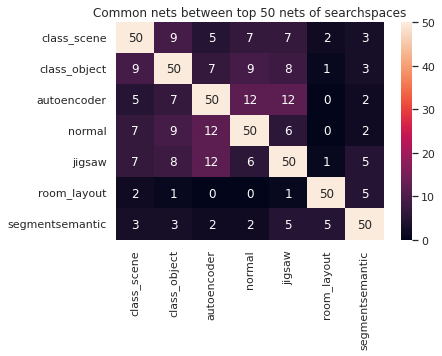

In [ ]:
_ = common_n_largest(dfs)

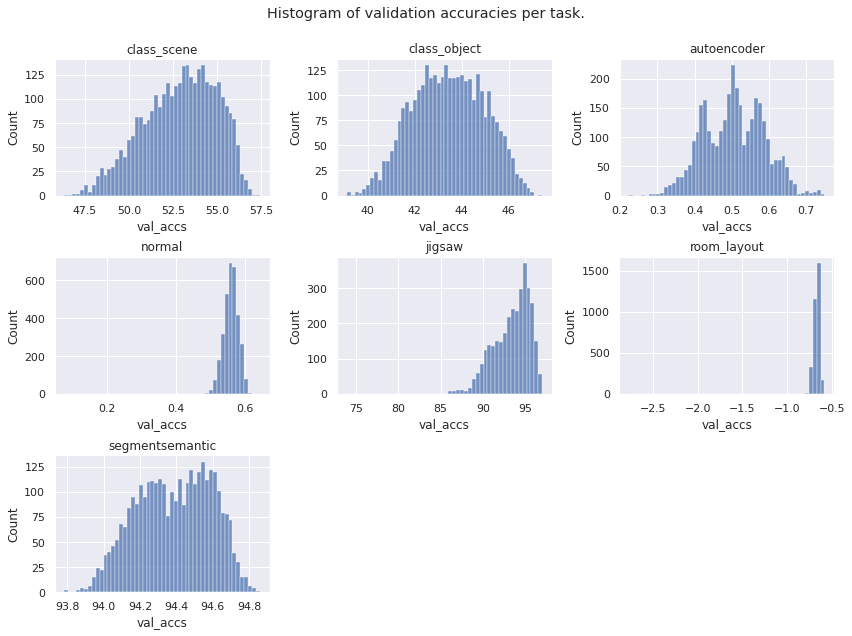

In [ ]:
plot_acc_hist(dfs)

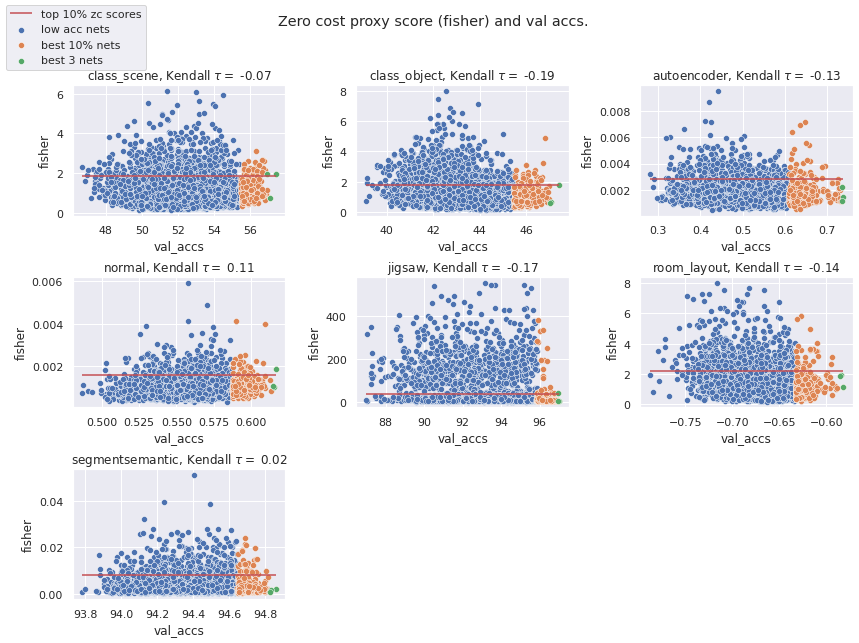

In [ ]:
zc = 'params'

plot_proxies(dfs, zc)

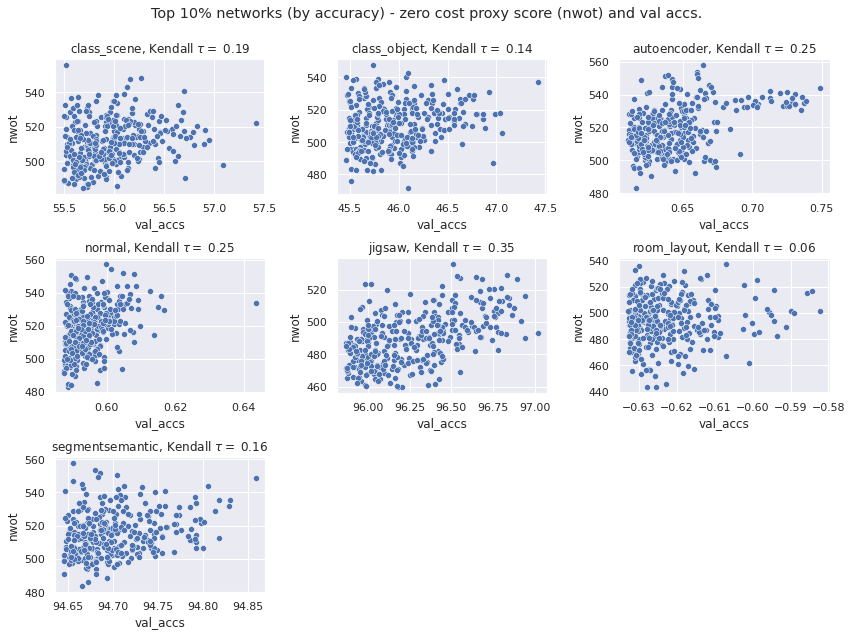

In [ ]:
plot_top_proxies(dfs, zc)

# NAS-Bench-201

In [ ]:
import json

what = 'zc_nasbench201'

with open(f'NASLib/naslib/data/{what}.json', 'r') as f:
    zc_nasbench201 = json.load(f)

In [ ]:
dfs_201 = parse_scores(zc_nasbench201)

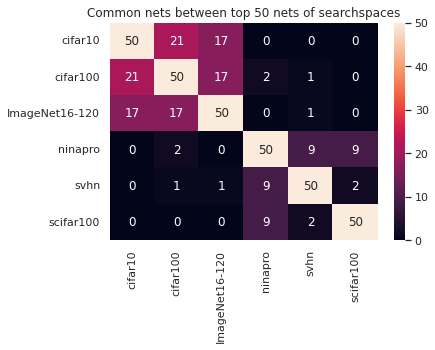

In [ ]:
_ = common_n_largest(dfs_201)

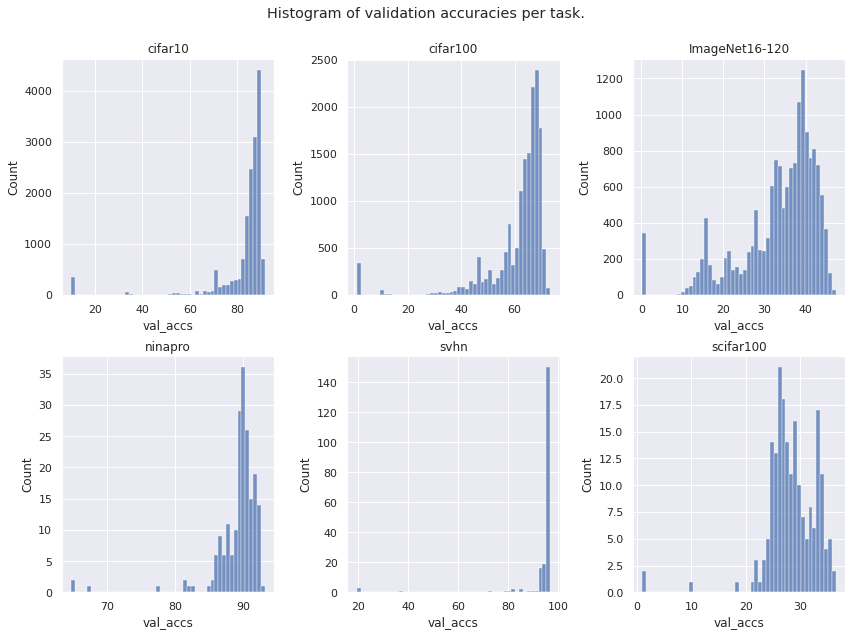

In [ ]:
plot_acc_hist(dfs_201)

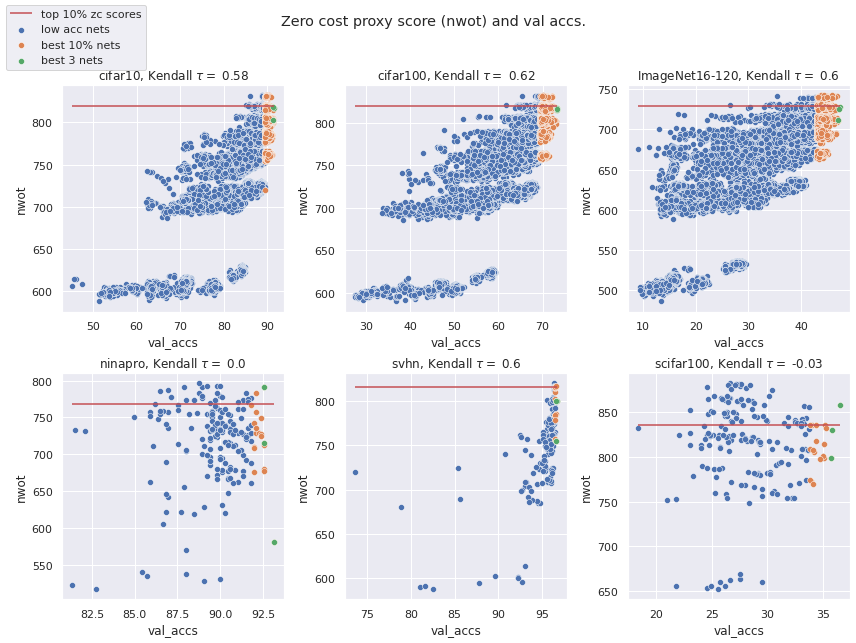

In [ ]:
zc = 'nwot'

plot_proxies(dfs_201, zc)

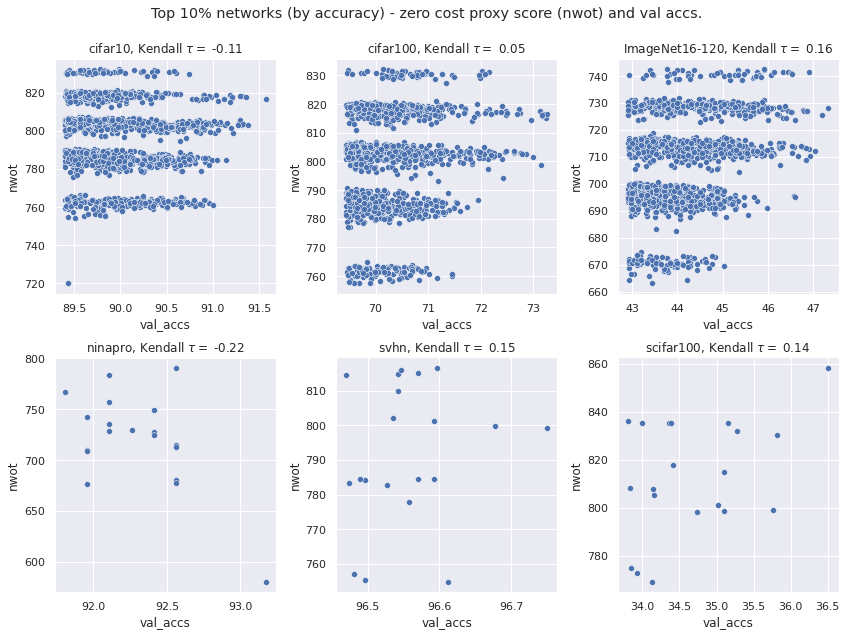

In [ ]:
plot_top_proxies(dfs_201, zc)

## Combine two proxies

## NB201 - nwot and synflow

3906
3906
3906
49
49
49


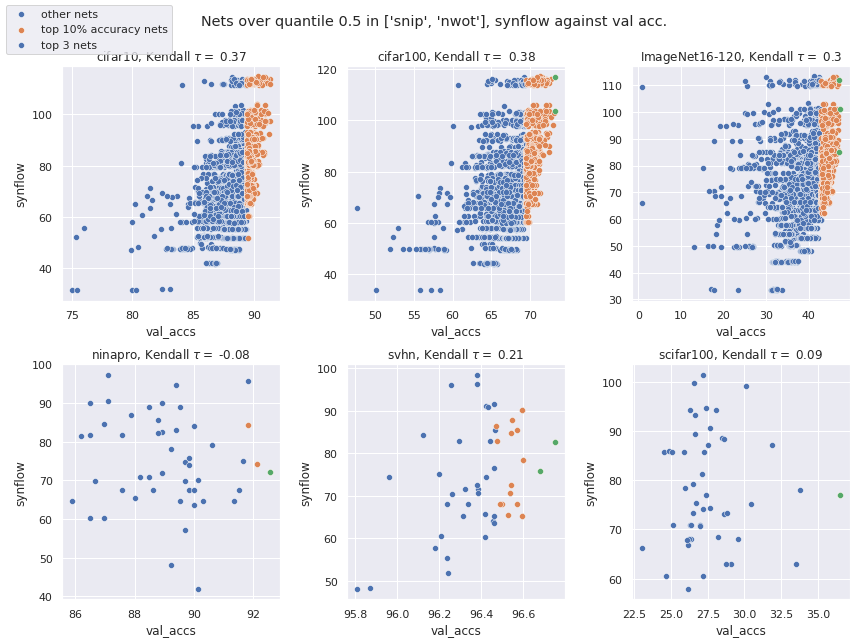

In [ ]:
plot_top_proxies_filtered(dfs_201, 'synflow', ['snip', 'nwot'], quantile=0.5, mode='s')

1563
1563
1563
20
20
20


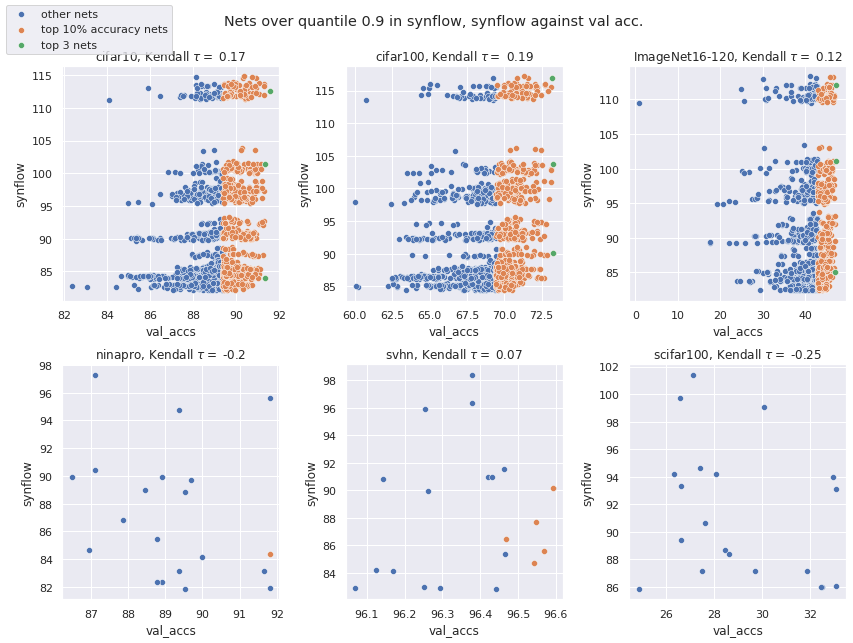

In [ ]:
plot_top_proxies_filtered(dfs_201, 'synflow', 'synflow')

1563
1563
1563
20
20
20


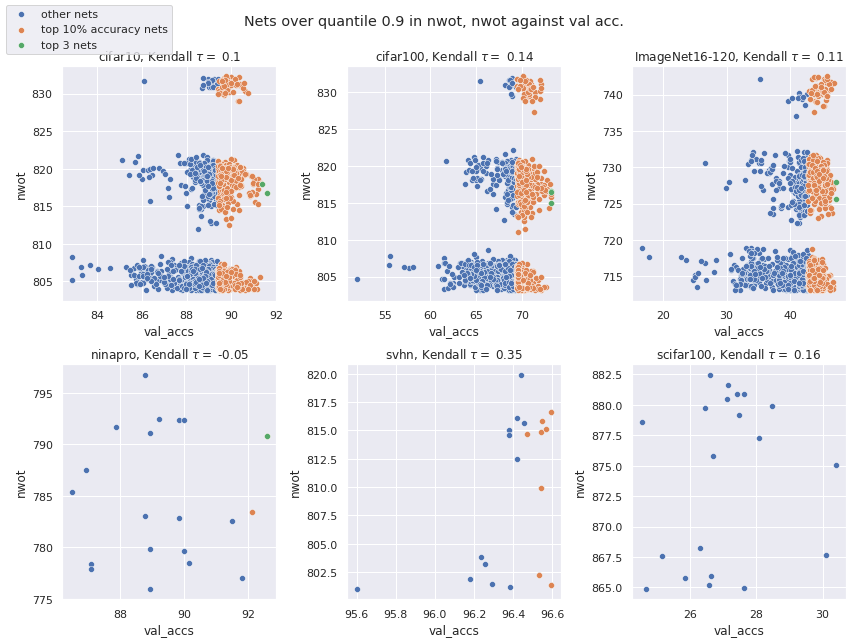

In [ ]:
plot_top_proxies_filtered(dfs_201, 'nwot', 'nwot')

1563
1563
1563
20
20
20


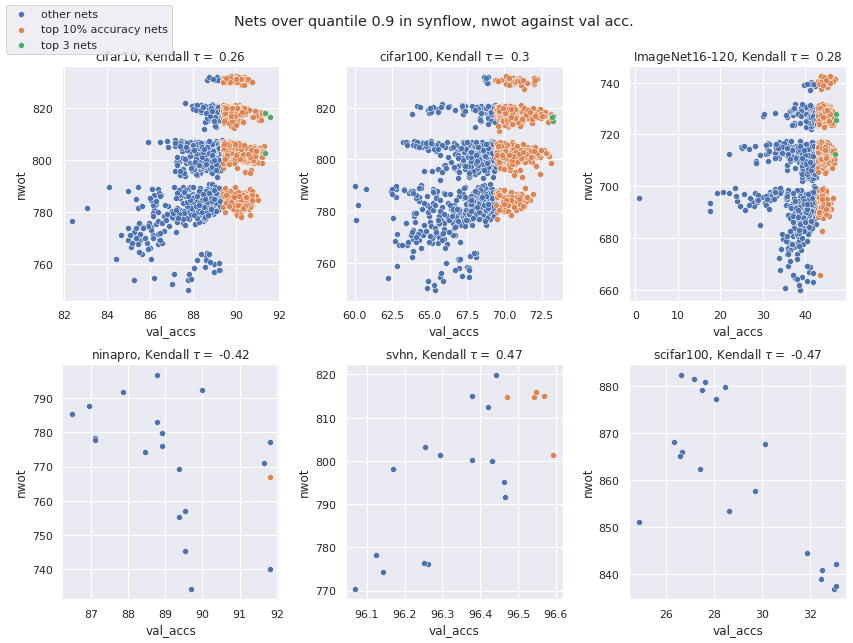

In [ ]:
plot_top_proxies_filtered(dfs_201, 'nwot', 'synflow')

## TransBench - nwot and flops

In [ ]:
zc_nasbench201['cifar10']['(4, 1, 1, 3, 0, 2)'].keys()

dict_keys(['id', 'epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen', 'val_accuracy'])

321
321
321
321
321
321
321


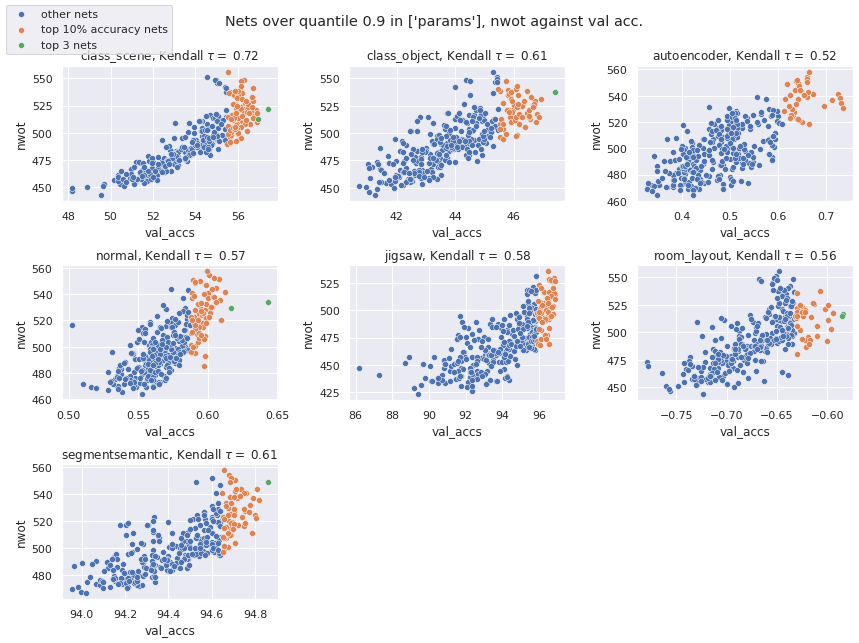

In [ ]:
plot_top_proxies_filtered(dfs, 'nwot', ['params'])

808
812
810
809
814
813
810


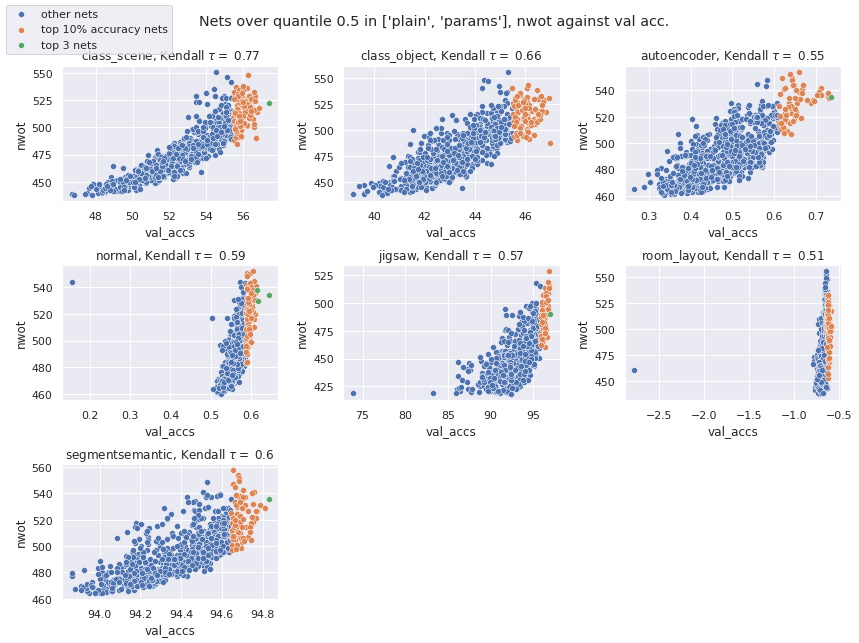

In [ ]:
plot_top_proxies_filtered(dfs, 'nwot', ['plain', 'params'], quantile=0.5, mode='s')

560
561
606
610
576
573
615


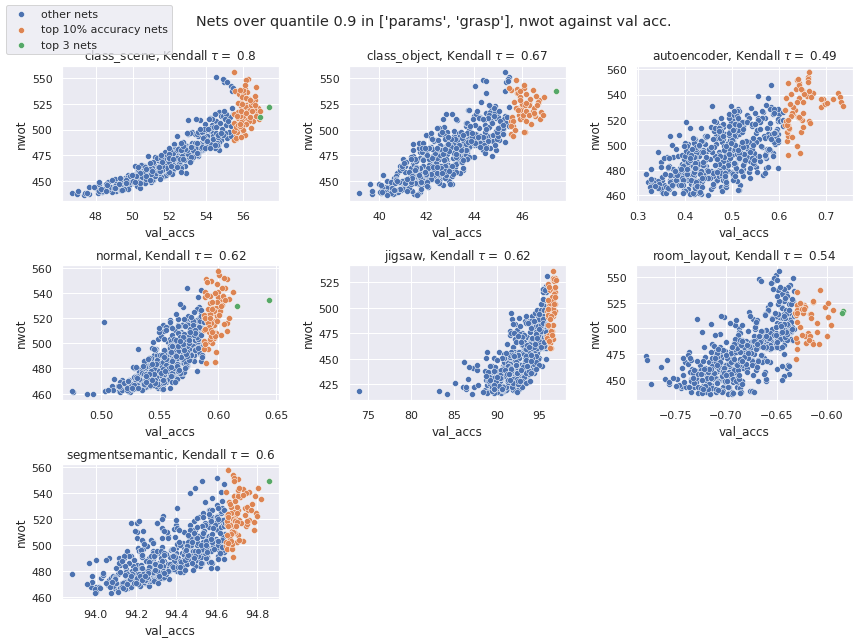

In [ ]:
plot_top_proxies_filtered(dfs, 'nwot', ['params', 'grasp'], mode='u')

326
326
326
326
326
326
326


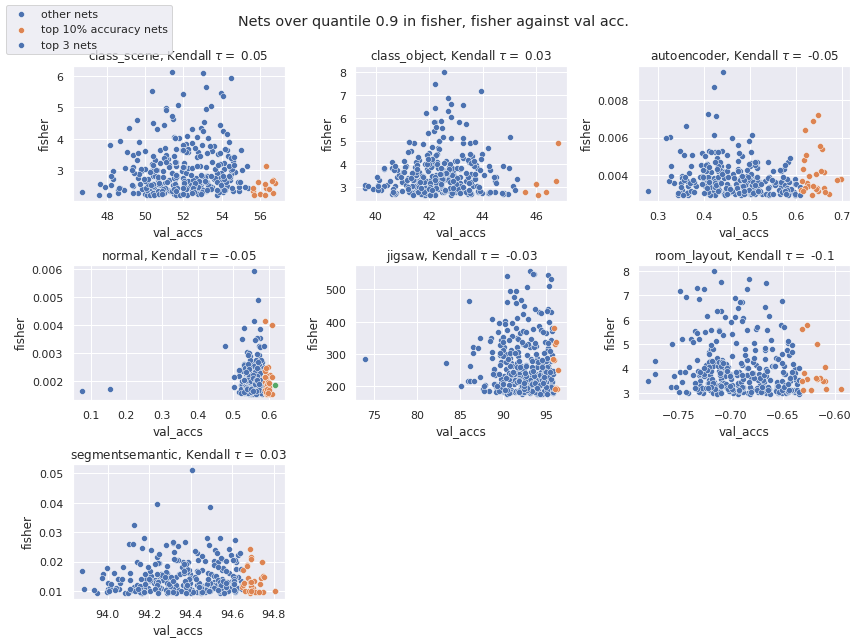

In [ ]:
plot_top_proxies_filtered(dfs, 'fisher', 'fisher')

326
326
326
326
326
326
326


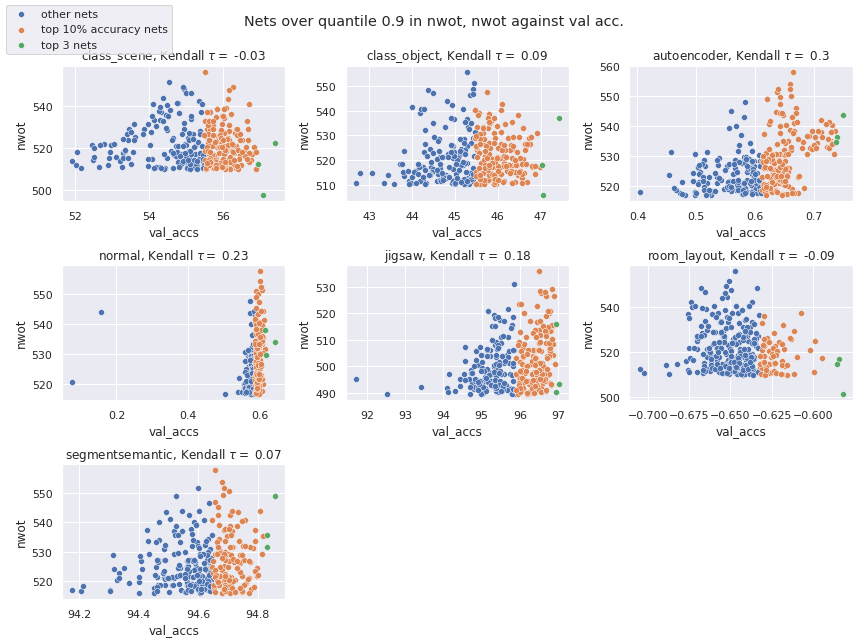

In [ ]:
plot_top_proxies_filtered(dfs, 'nwot', 'nwot')

326
326
326
326
326
326
326


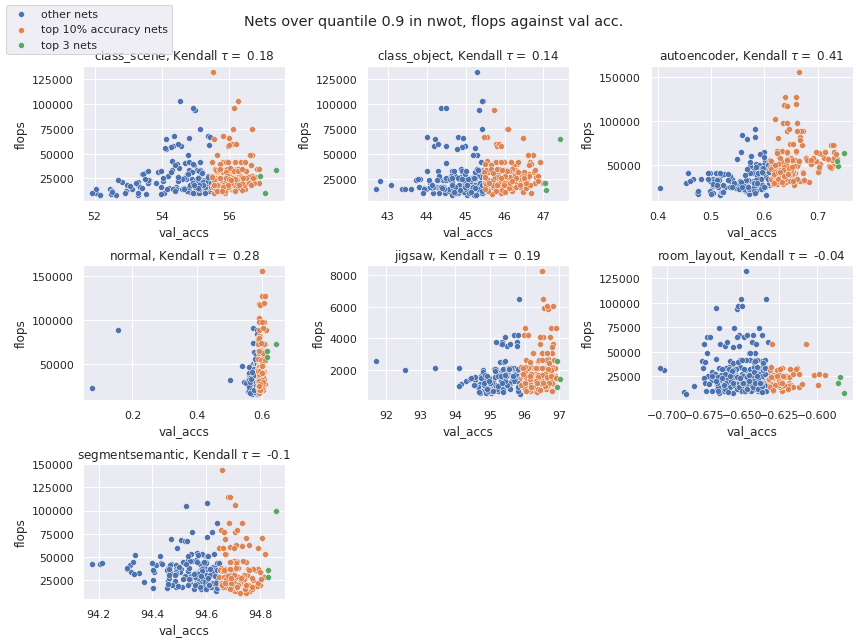

In [ ]:
plot_top_proxies_filtered(dfs, 'flops', 'nwot')

## Voting from Abdelfettah et al.

In [ ]:
concordant = {}
vote = {}
ranks = {}

In [ ]:
import numpy as np

dfs_what = dfs
dataset = 'segmentsemantic'
df = dfs[dataset]

concordant[dataset] = 0
vote[dataset] = []
ranks[dataset] = []
print(dataset)

for i in range(len(df)):
  if i % 5000 == 0:
    print(i)

  diffs = [(df.iloc[i][m] - df[m]) for m in ['synflow', 'jacov', 'snip']]
  diffs = np.sign(sum([np.sign(d) for d in diffs]))
  vote[dataset].append(diffs)

  true_rank = np.sign(df.iloc[i]['val_accs'] - df['val_accs'])
  ranks[dataset].append(true_rank)

  concordant[dataset] += np.sum((true_rank * diffs) > 0)

segmentsemantic
0


In [ ]:
vote_matrix = np.array(vote[dataset])
rank_matrix = np.array(ranks[dataset])
index = df[df['nwot'] > df['nwot'].quantile(0.9)].index

top_votes = np.triu(vote_matrix[index][:, index])
top_ranks = np.triu(rank_matrix[index][:, index])

num = len(top_votes) * len(top_votes) / 2 - len(top_votes) / 2
print(dataset, np.sum(top_ranks == top_votes) - num)
print((np.sum(top_ranks == top_votes) - num) / num)

segmentsemantic 12028.0
0.2270504955167532


In [ ]:
for d, c in concordant.items():
  l = len(dfs[d])
  pairs = c / 2 - l / 2
  possible = l * l /2 - l / 2
  print(d, pairs / possible)

segmentsemantic 0.44770377834893965
